In [1]:
from libdatasets import *
import librun
import libstop
from importlib import reload
from libadversarial import uncertainty_stop
from libstop import rank_stop_conds
from dotenv import load_dotenv; load_dotenv();

### Decision Trees

In [2]:
matrix = {
    # Dataset fetchers should cache if possible
    # Lambda wrapper required for function to be pickleable (sent to other threads via joblib)
    "datasets": [
        ("rcv1", wrap(rcv1, None)),
        ("webkb", wrap(webkb, None)),
        ("spamassassin", wrap(spamassassin, None)),
        ("avila", wrap(avila, None)),
        ("smartphone", wrap(smartphone, None)),
        ("swarm", wrap(swarm, None)),
        ("sensorless", wrap(sensorless, None)),
        ("splice", wrap(splice, None)),
        ("anuran", wrap(anuran, None)),
    ],
    "dataset_mutators": {
        "none": (lambda *x, **kwargs: x),
    },
    "methods": [
        ("uncertainty", partial(uncertainty_stop, n_instances=10)),
    ],
    "models": [
        "decision-tree"
    ],
    "meta": {
        "dataset_size": 1000,
        "labelled_size": 10,
        "test_size": 0.5,
        "n_runs": 10,
        "ret_classifiers": True,
        "ensure_y": True,
        "stop_info": True,
        "aggregate": False,
        "stop_function": ("len1000", lambda learner: learner.y_training.shape[0] >= 1000),
        "pool_subsample": 1000
    }
}

In [3]:
reload(librun)
results = librun.run(matrix, force_cache=True, fragment_run_start=0, fragment_run_end=9)
results_plots = [result[0] for result in results]
classifiers = [result[1] for result in results]
classifiers = [clf for clf in classifiers]

['C:\\Users\\Zac\\AppData\\Local\\pypoetry\\Cache\\virtualenvs\\research-KKf5lz0r-py3.8\\lib\\site-packages\\ipykernel_launcher.py', '-f', 'C:\\Users\\Zac\\AppData\\Roaming\\jupyter\\runtime\\kernel-0caa07ba-92a3-4221-921a-9ce1475b4fb7.json']


Experiment:   0%|          | 0/9 [00:00<?, ?it/s]

In [4]:
for plots, clfs in zip(results_plots, classifiers):
    for i, clfs_ in enumerate(clfs):
        if len(clfs_) != 100:
            print(f"{plots[0].serialize()}_{i}.zip")

In [5]:
reload(libstop)
stop_conditions, stop_results = libstop.eval_stopping_conditions(results_plots, classifiers)

In [6]:
from itertools import groupby
def f():
    table = np.ones((len(stop_results), len(next(iter(stop_results.values())))))
    for i, (dataset, results) in enumerate(stop_results.items()):
        for j, (method, runs) in enumerate(results.items()):
            percent = np.count_nonzero([run[0] for run in runs])/len(runs)
            table[i][j] = percent
            
    skip = [(table[:,i]!=1.0).any() for i in range(len(table[0]))]
    table = table[:,skip]
    return table, skip
    
t, skip = f()
print(tabulate(
    t,
    showindex=stop_results.keys(), 
    headers=["dataset", *np.array(list(stop_results[list(stop_results.keys())[0]].keys()))[skip]], floatfmt=".0%", tablefmt='latex'
))

\begin{tabular}{lrrr}
\hline
 dataset      &   VM &   EVM &   stabilizing\_predictions \\
\hline
 rcv1         &   0\% &    0\% &                        0\% \\
 webkb        &   0\% &    0\% &                        0\% \\
 spamassassin &   0\% &    0\% &                       10\% \\
 avila        &   0\% &    0\% &                        0\% \\
 smartphone   &   0\% &    0\% &                        0\% \\
 swarm        &   0\% &    0\% &                       30\% \\
 sensorless   &   0\% &    0\% &                        0\% \\
 splice       &  30\% &   30\% &                        0\% \\
 anuran       &   0\% &    0\% &                        0\% \\
\hline
\end{tabular}


C:\Users\Zac\AppData\Local\pypoetry\Cache\virtualenvs\research-KKf5lz0r-py3.8\lib\site-packages\autorank\_util.py:107: RuntimeWarning: invalid value encountered in double_scalars
  return (np.median(x) - np.median(y)) / _pooled_mad(x, y)
C:\Users\Zac\AppData\Local\pypoetry\Cache\virtualenvs\research-KKf5lz0r-py3.8\lib\site-packages\autorank\_util.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  return (np.median(x) - np.median(y)) / _pooled_mad(x, y)


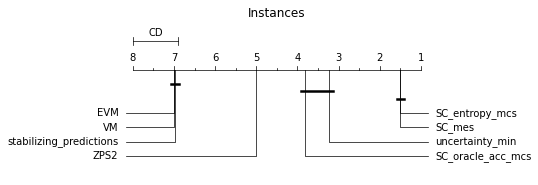

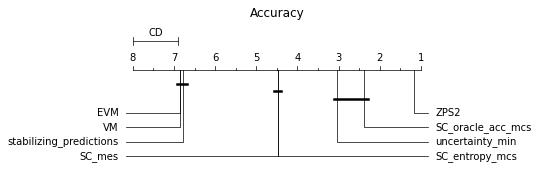

In [7]:
reload(libstop); from libstop import rank_stop_conds; import matplotlib.pyplot as plt
#fig, axes = plt.subplots(1,2, figsize=(16,3))
ax1 = rank_stop_conds(stop_results, results_plots, 'instances', )#ax=axes[0])
ax2 = rank_stop_conds(stop_results, results_plots, 'accuracy_score', );#ax=axes[1]);
ax1.figure.savefig('figures/base_instances.png', bbox_inches='tight')
ax2.figure.savefig('figures/base_accuracy.png', bbox_inches='tight')

C:\Users\Zac\Programming\python\research\librun.py:464: RuntimeWarning: invalid value encountered in true_divide
  ax2.plot(metrics[0].x[1:], ee_first/np.max(np.abs(ee_first[2:])), label='1st')
C:\Users\Zac\Programming\python\research\librun.py:465: RuntimeWarning: invalid value encountered in true_divide
  ax2.plot(metrics[0].x[3:], ee_second/np.max(np.abs(ee_second[2:])), label='2nd')
C:\Users\Zac\Programming\python\research\librun.py:464: RuntimeWarning: invalid value encountered in true_divide
  ax2.plot(metrics[0].x[1:], ee_first/np.max(np.abs(ee_first[2:])), label='1st')
C:\Users\Zac\Programming\python\research\librun.py:465: RuntimeWarning: invalid value encountered in true_divide
  ax2.plot(metrics[0].x[3:], ee_second/np.max(np.abs(ee_second[2:])), label='2nd')
C:\Users\Zac\Programming\python\research\librun.py:464: RuntimeWarning: invalid value encountered in true_divide
  ax2.plot(metrics[0].x[1:], ee_first/np.max(np.abs(ee_first[2:])), label='1st')
C:\Users\Zac\Programming\p

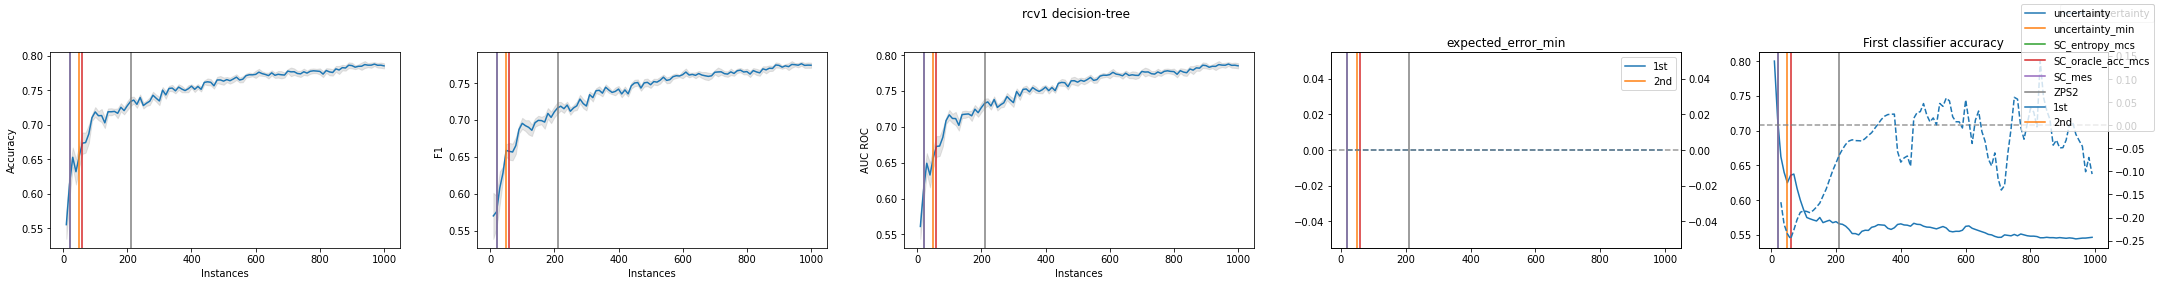

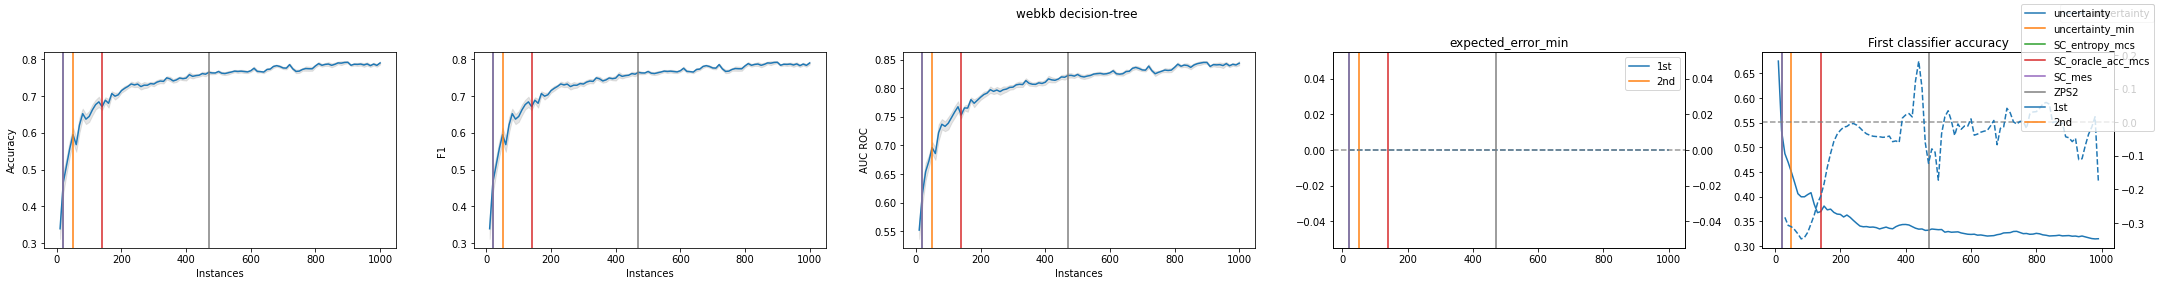

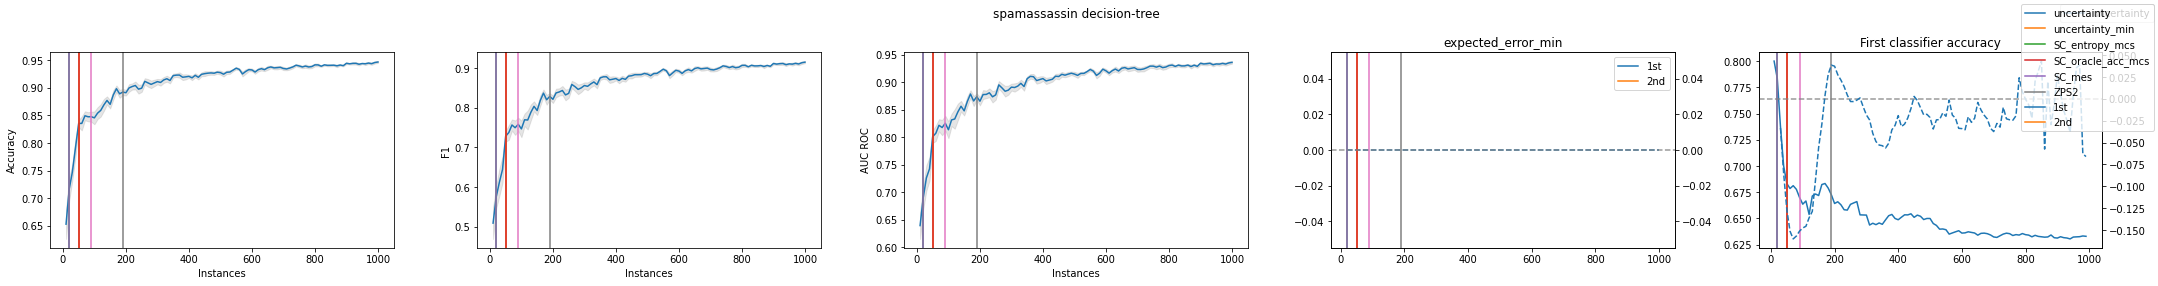

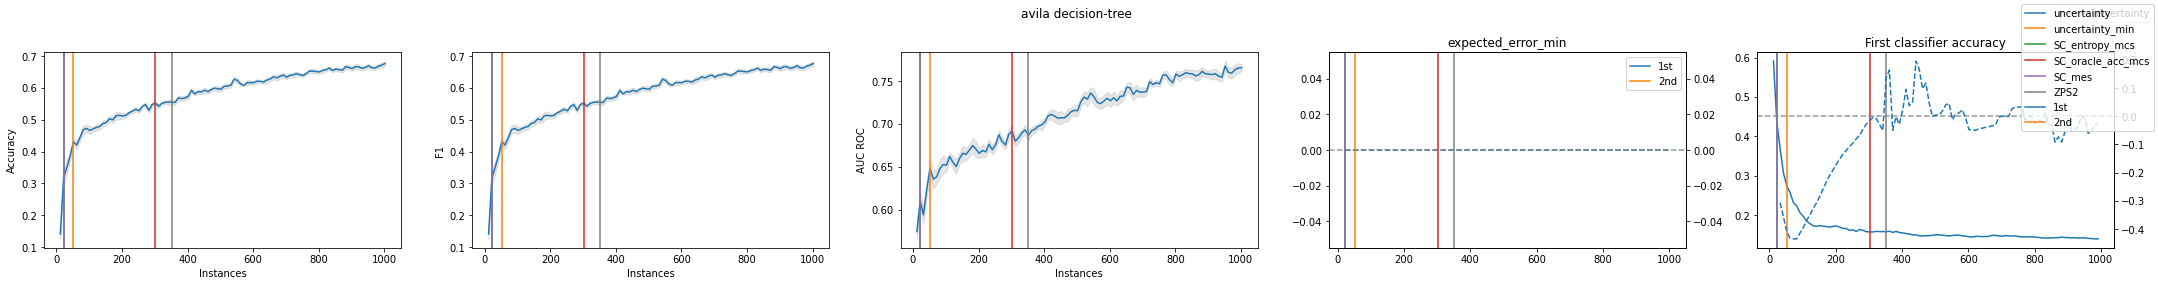

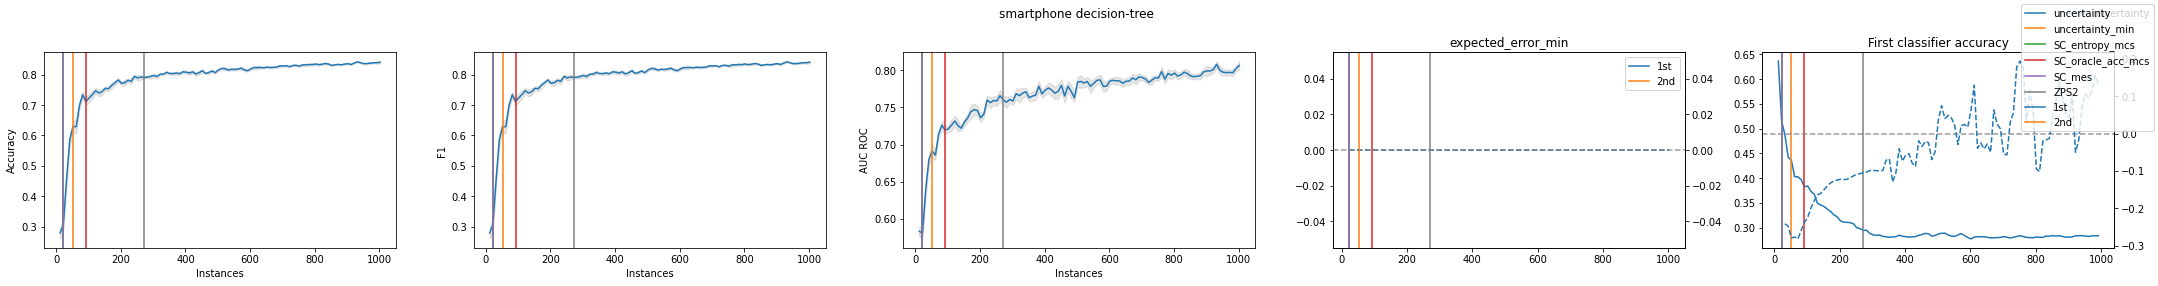

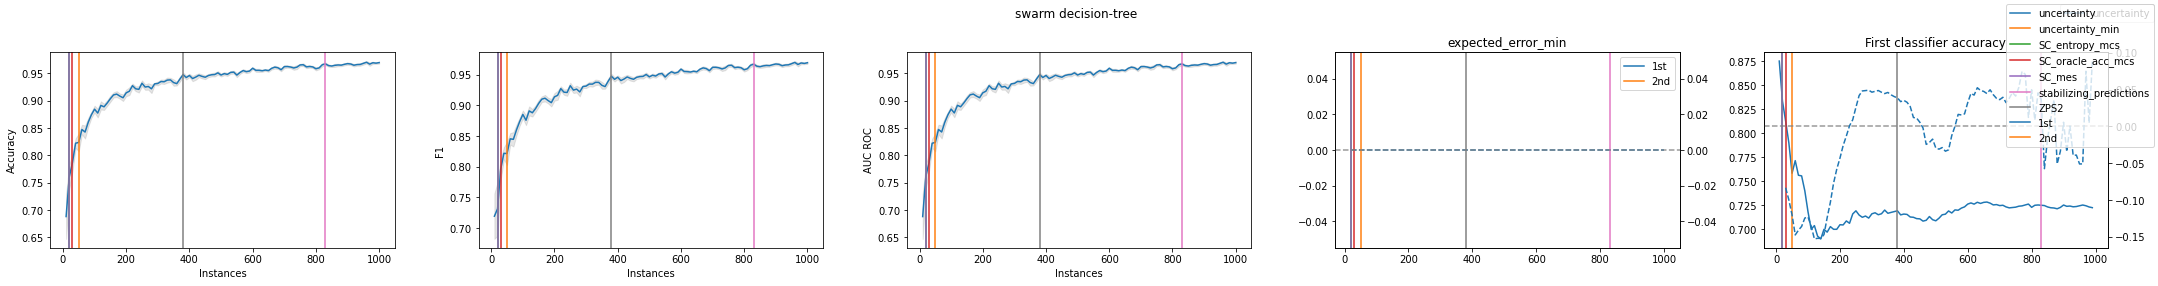

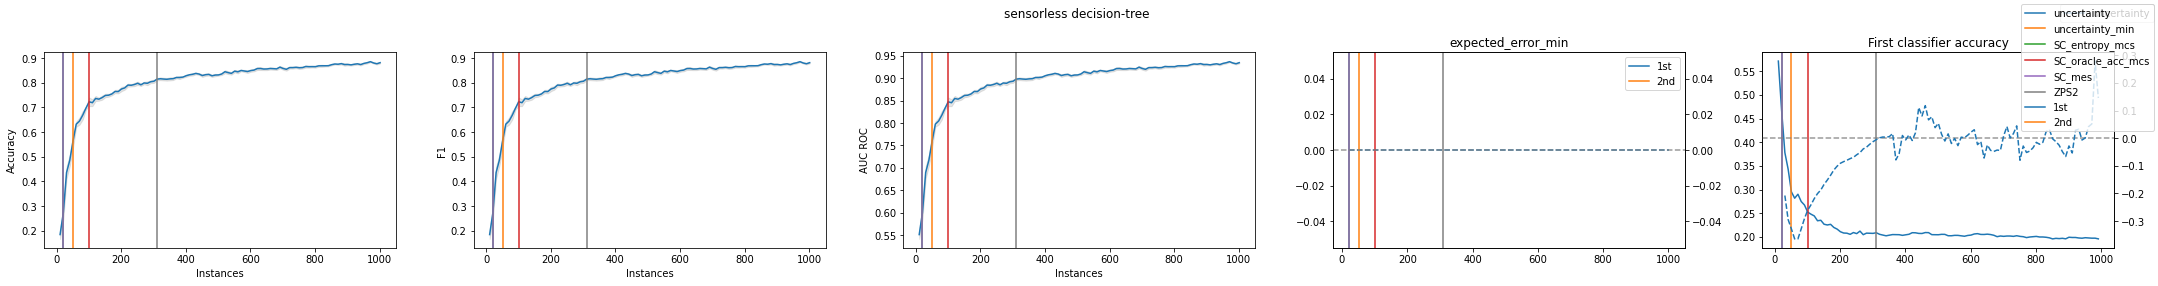

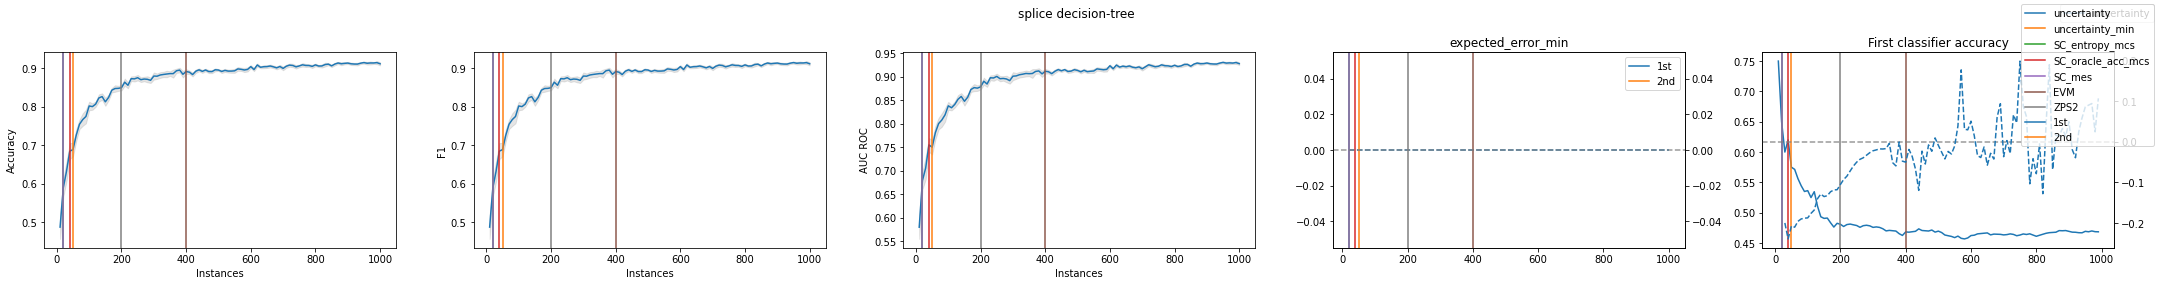

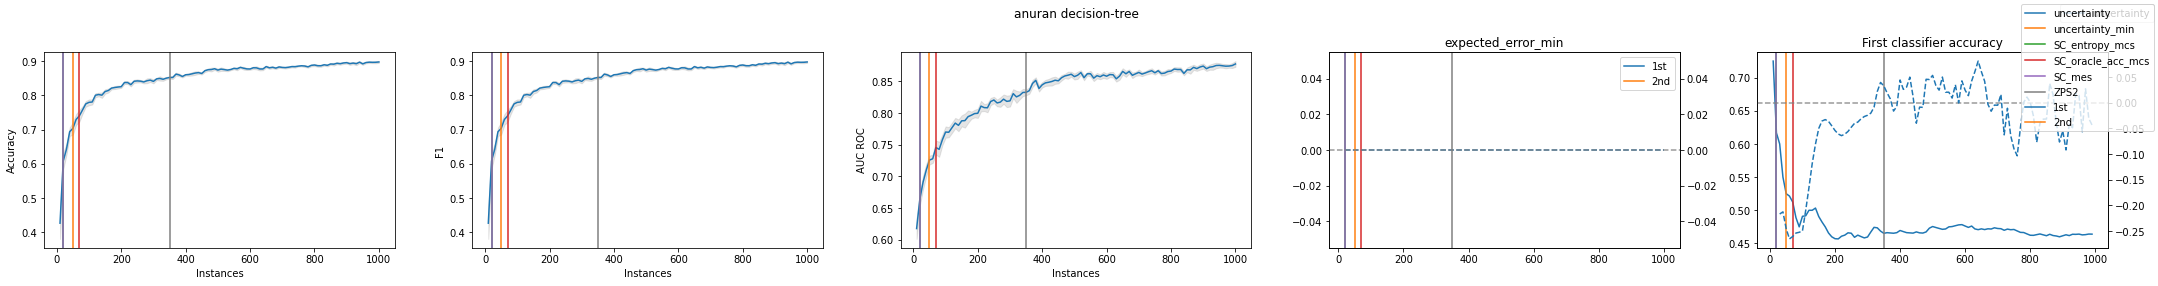

In [11]:
reload(librun)
librun.plot_stop(results_plots, classifiers, stop_conditions, stop_results, figsize=(30, 4), scale='linear') # scale='logit'

In [36]:
def plot_stop(plots, classifiers, stop_conditions, stop_results, scale='linear', figsize=(18, 4)):
    import libdatasets; from libactive import active_split; from sklearn.utils import check_random_state; from libstop import kappa_metric
    figaxes = librun.plot(plots, ret=True, sort=False, extra=1, scale=scale, figsize=figsize)
    for i, (fig, ax) in enumerate(figaxes):
        clfs = classifiers[i]
        metrics = plots[i][1]
        conf = plots[i][0]
        
        for j, clfs_ in enumerate(clfs):
            if len(clfs_) < 100:
                raise Exception(f'short classifier file: {plots[i][0].serialize()}_{j}.zip\nIt has length {len(clfs_)} when it should have length 100')
        
        if plots[i][0].dataset_mutator_name != 'none':
            scores = __get_passive_scores(plots[i][0], range(len(plots[i][1])))
            for ax, score in zip(ax, scores):
                ax.axhline(score, color='tab:gray', ls='--')
            
        prop_cycle = plt.rcParams['axes.prop_cycle']
        colors = prop_cycle.by_key()['color']
        
        X, y = getattr(libdatasets, conf.dataset_name)(None)
        unlabelled_pools = []
        y_oracles = []
        # WARN: This is not the same as the job numbers! Unfortunately they're not easily accessible
        for i in range(len(results)):
            _, X_unlabelled, _, Y_oracle, _, _ = active_split(
                X, y, labeled_size=conf.meta['labelled_size'], test_size=conf.meta['test_size'], random_state=check_random_state(i), ensure_y=conf.meta['ensure_y']
            )
            unlabelled_pools.append(X_unlabelled)
            y_oracles.append(Y_oracle)
        
        # x, classifiers, X_unlabelled
        ax[-1].plot(metrics[0].x, kappa_metric(metrics[0].x, clfs[0], unlabelled_pools[0]))
        ax[-1].axhline(0.99, color='grey', ls='--')
        ax[-1].set_title("Kappa metric")
        

        for ii, a in enumerate(ax):        
            for iii, (name, cond) in enumerate(stop_conditions.items()):
                stops = stop_results[plots[i][0].dataset_name][name]
                for iiii, stop in enumerate(stops):
                    if stop[0] is not None:
                        #print(stop)
                        a.axvline(stop[0], label=name if ii == 0 and iiii ==0 else None, color=colors[(iii+1) % len(colors)])
                        break

        fig.legend(bbox_to_anchor=(1.1, 0.5), loc='center right',)
        fig.tight_layout()


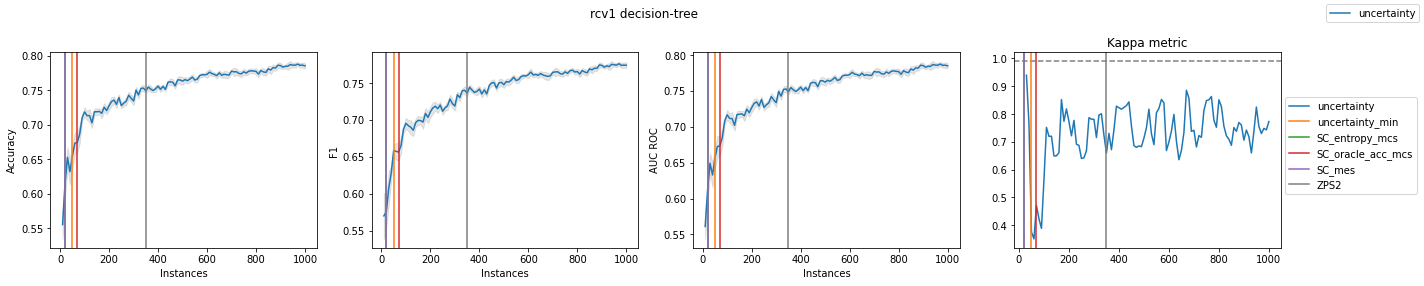

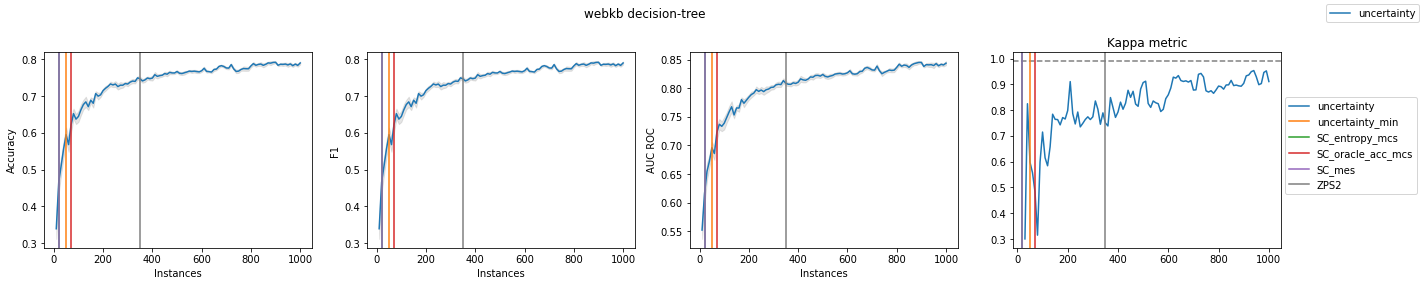

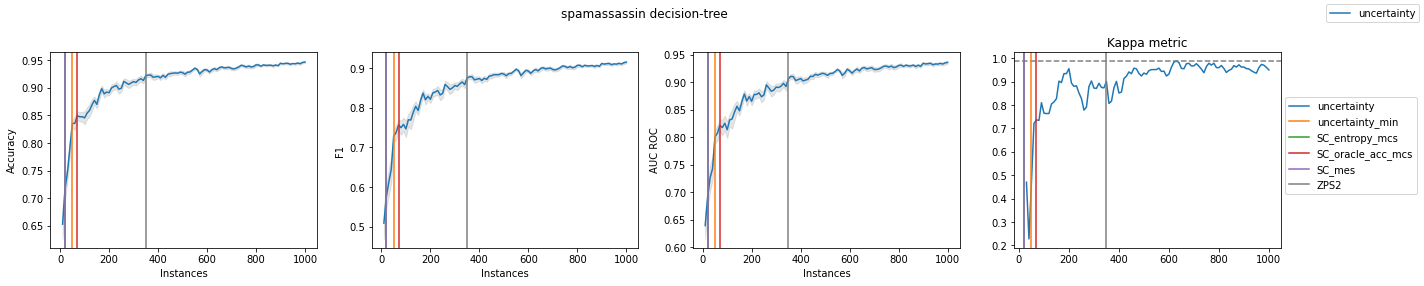

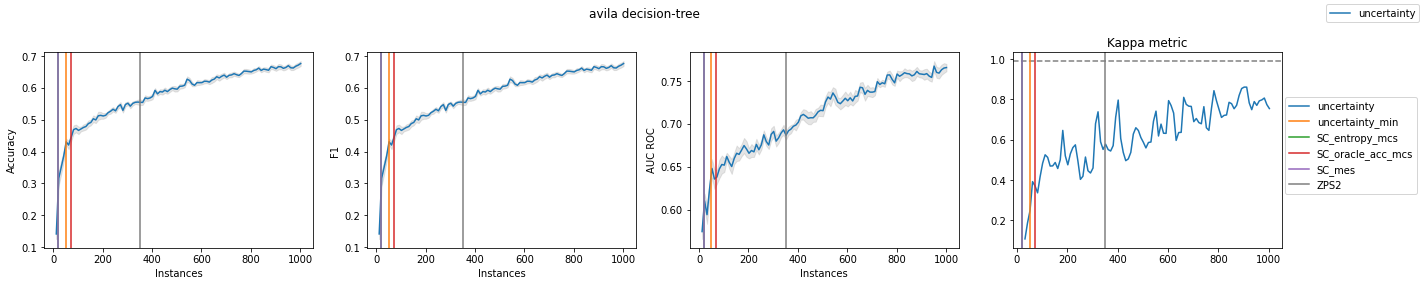

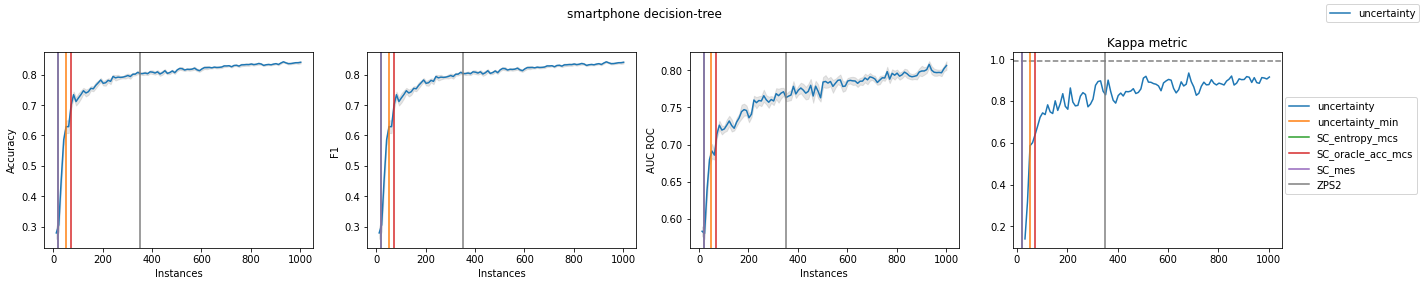

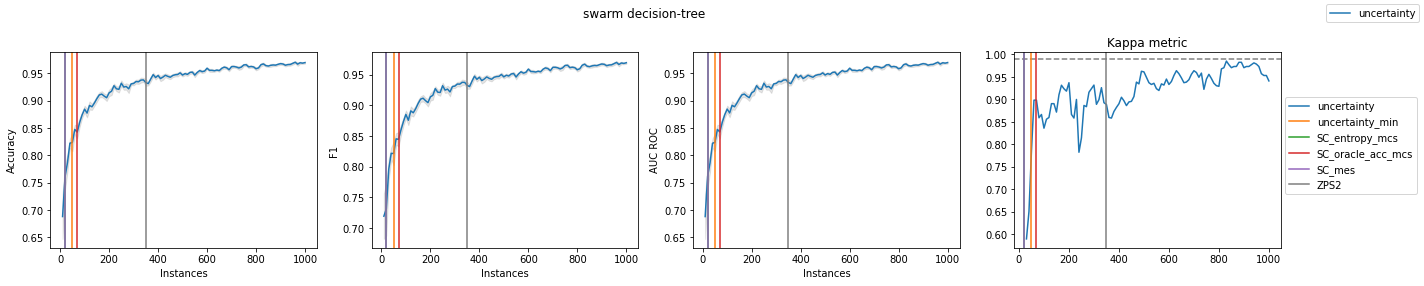

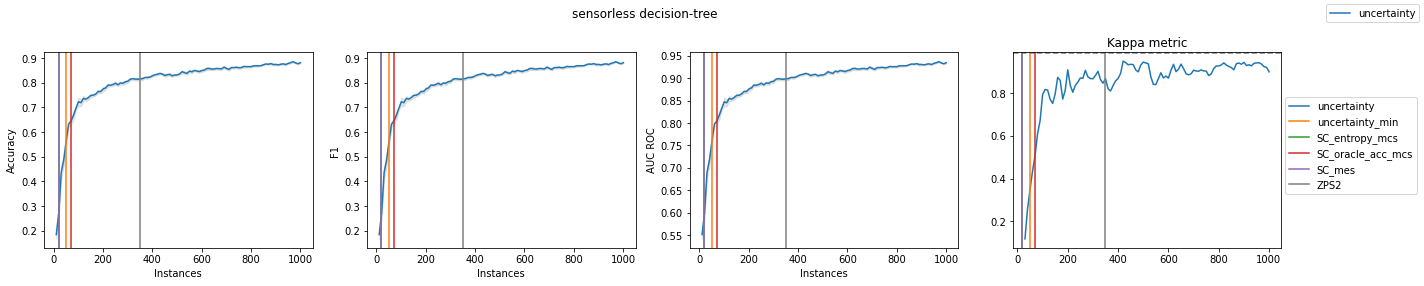

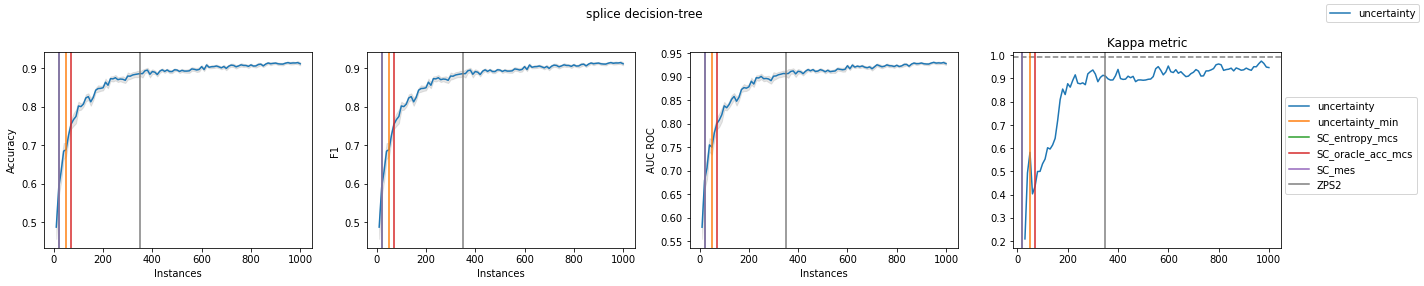

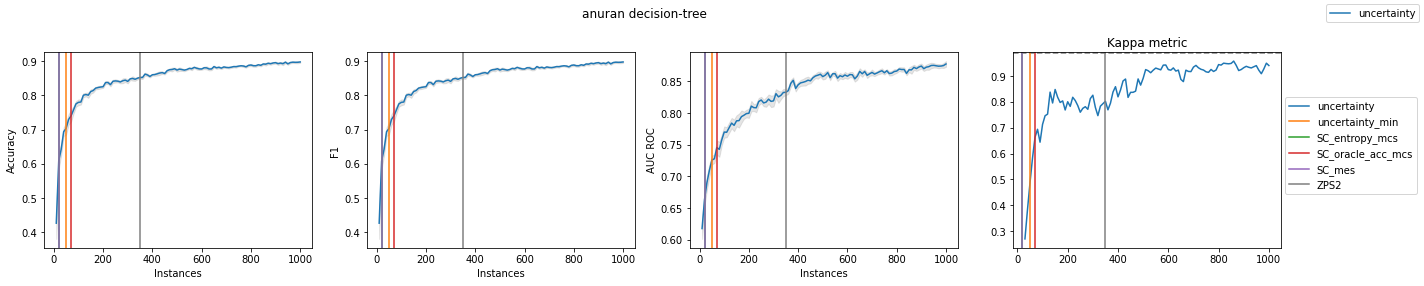

In [37]:
plot_stop(results_plots, classifiers, stop_conditions, stop_results)

## Random Forest

In [40]:
matrix = {
    # Dataset fetchers should cache if possible
    # Lambda wrapper required for function to be pickleable (sent to other threads via joblib)
    "datasets": [
        ("rcv1", wrap(rcv1, None)),
        ("webkb", wrap(webkb, None)),
        ("spamassassin", wrap(spamassassin, None)),
        ("avila", wrap(avila, None)),
        #("smartphone", wrap(smartphone, None)),
        ("swarm", wrap(swarm, None)),
        ("sensorless", wrap(sensorless, None)),
        ("splice", wrap(splice, None)),
        ("anuran", wrap(anuran, None)),
    ],
    "dataset_mutators": {
        "none": (lambda *x, **kwargs: x),
    },
    "methods": [
        ("uncertainty", partial(uncertainty_stop, n_instances=10)),
    ],
    "models": [
        "random-forest"
    ],
    "meta": {
        "dataset_size": 1000,
        "labelled_size": 10,
        "test_size": 0.5,
        "n_runs": 10,
        "ret_classifiers": True,
        "ensure_y": True,
        "stop_info": True,
        "aggregate": False,
        "stop_function": ("len1000", lambda learner: learner.y_training.shape[0] >= 1000),
        "pool_subsample": 1000
    }
}

In [41]:
reload(librun)
results = librun.run(matrix, force_cache=True, fragment_run_start=0, fragment_run_end=9)
results_plots = [result[0] for result in results]
classifiers = [result[1] for result in results]
classifiers = [clf for clf in classifiers]

['C:\\Users\\Zac\\AppData\\Local\\pypoetry\\Cache\\virtualenvs\\research-KKf5lz0r-py3.8\\lib\\site-packages\\ipykernel_launcher.py', '-f', 'C:\\Users\\Zac\\AppData\\Roaming\\jupyter\\runtime\\kernel-0caa07ba-92a3-4221-921a-9ce1475b4fb7.json']


Experiment:   0%|          | 0/8 [00:00<?, ?it/s]

In [42]:
for plots, clfs in zip(results_plots, classifiers):
    for i, clfs_ in enumerate(clfs):
        if len(clfs_) != 100:
            print(f"{plots[0].serialize()}_{i}.zip")